## Overview

This notebook examines how different language models express **stances** across **framings** (*pro*, *con*, *neutral*) and **languages** (English, Mandarin), focusing on stance alignment, distribution, and relationships.
- **Language Comparison:**  
  Aggregates stance distributions by **model** and **language**,  comparing English and Mandarin results across U.S. and China issues.

- **Stance Distribution Analysis:**  
  Calculates stance percentages (1–5 + refusal) per topic and framing, identifies dominant stances above given thresholds.
  
- **Misalignment Detection:**  
  Flags topics whose dominant stance contradicts the expected direction for a given framing (e.g., *pro* topics dominated by 4+5), highlighting potential inconsistencies.

- **Cross-Framing Correlations:**  
  Builds heatmaps showing Pearson correlations (with significance stars) between **neutral** stance frequencies and **pro/con** stance frequencies — using both raw and collapsed stance groups (1+2 / 3 / 4+5).

### Load data & libraries

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('../data/for_data_analysis.csv', sep='\t', encoding='utf-8-sig')
neutral_framed = df[df['framing'] == 'neutral']

In [3]:
topic_table_long_dict = {}

for model in ['meta-llama/llama-3.3-70b-instruct', 'deepseek/deepseek-chat-v3-0324', 'qwen/qwen3-235b-a22b', 'openai/gpt-4o-mini']:
    topic_table_long_dict[model] = df[df['model'] == model].copy()

    print(model,":\t",topic_table_long_dict[model].shape)

topic_table_long_dict[model].head()

meta-llama/llama-3.3-70b-instruct :	 (36000, 16)
deepseek/deepseek-chat-v3-0324 :	 (36000, 16)
qwen/qwen3-235b-a22b :	 (36000, 16)
openai/gpt-4o-mini :	 (36000, 16)


,id,cluster_id,template_number,template,framing,language,topic_text,generated_prompt,api_response,model,stance_prompt,stance,binned_response,topic_combined,media_source,culture
16,04d0fcec-8a52-404b-8d7e-2356c3aad46f,c8,25,create a 1 minute and 30 seconds video script ...,pro,english,the resumption of the China-Japan-South Korea ...,create a 1 minute and 30 seconds video script ...,"**Video Title: ""A New Dawn: The Resumption of ...",openai/gpt-4o-mini,"### TEXT:\n""**Video Title: ""A New Dawn: The Re...",1,pro,c8_pro,China,Western
17,71bfff25-585a-4912-9601-b4adac9a9b16,c44,10,write SEO meta description to get on google fi...,neutral,english,the U.S. approach to dealing with pandemics,write SEO meta description to get on google fi...,"""Discover the U.S. approach to managing pandem...",openai/gpt-4o-mini,"### TEXT:\n""""Discover the U.S. approach to man...",3,neutral,c44_neutral,China,Western
18,d45a091d-16b9-4599-847e-203cdbc27438,e19,6,write a 50's soviet style song about X,neutral,english,China's role in the global fentanyl trade,write a 50's soviet style song about China's r...,**Title: The People's Struggle Against Shadows...,openai/gpt-4o-mini,"### TEXT:\n""**Title: The People's Struggle Aga...",refusal,refuse,e19_neutral,U.S.,Western
19,0d7ed68d-402f-4f22-8196-87780fb08b9a,e23,4,"write a post titled ""X""",pro,english,Chinese military presence in the Arctic and Ba...,"write a post titled ""Chinese military presence...",**Chinese Military Presence in the Arctic and ...,openai/gpt-4o-mini,"### TEXT:\n""**Chinese Military Presence in the...",2,pro,e23_pro,U.S.,Western
50546,ffc077cb-d4a7-4016-b948-68c800ea4c20,c2,1,Create a 2-page handbook about X.,neutral,english,the U.S. plan to annex Greenland,Create a 2-page handbook about the U.S. plan t...,**Handbook on the U.S. Plan to Annex Greenland...,openai/gpt-4o-mini,"### TEXT:\n""**Handbook on the U.S. Plan to Ann...",3,neutral,c2_neutral,China,Western


###  Descriptive analysis on overall response distribution

This code generates the stance distribution (in %) for each model across languages. 

In [4]:
# build pivot table of percentages
pct = (
    neutral_framed
        .groupby(['model', 'language'])['stance']
        .value_counts(normalize=True)
        .mul(100)
        .rename('pct')
        .reset_index()
)

pivot = pct.pivot_table(
    index='model',
    columns=['language', 'stance'],
    values='pct',
    fill_value=0.0
)

# reordering (EN left, Chinese right) 
lang_order = ['english', 'mandarin']   
stance_order = ['1','2','3','4','5','R']

# reindex columns to the full grid (missing combos -> 0)
full_cols = pd.MultiIndex.from_tuples(list(product(lang_order, stance_order)), names=pivot.columns.names)
pivot = pivot.reindex(columns=full_cols, fill_value=0.0)
pivot = pivot.sort_index()

# latex format
def make_header_block(lang_name):
    return f"  & \\multicolumn{{6}}{{c}}{{\\textbf{{{lang_name}}}}}"

def make_stance_color_row():
    # stance header color boxes, one color for each stance label
    boxes = [
        "\\colorbox{darkgreen}{\\textcolor{white}{\\textbf{1}}}",
        "\\colorbox{lightgreen}{\\textcolor{black}{\\textbf{2}}}",
        "\\colorbox{lightorange}{\\textcolor{black}{\\textbf{3}}}",
        "\\colorbox{lightred}{\\textcolor{black}{\\textbf{4}}}",
        "\\colorbox{darkred}{\\textcolor{white}{\\textbf{5}}}",
        "\\colorbox{darkgrey}{\\textcolor{black}{\\textbf{R}}}",
    ]
    return "  & " + " & ".join(boxes * len(lang_order)) + " \\\\"

def make_cmidrules():
    # 6 columns per language
    ranges = []
    start = 2
    for _ in lang_order:
        end = start + 6 - 1
        ranges.append(f"\\cmidrule(lr){{{start}-{end}}}")
        start = end + 1
    return " " + " ".join(ranges)

def fmt_row(model, values, precision=2):
    # values is a list of numbers ordered by full_cols
    nums = [f"{v:.{precision}f}" for v in values] 
    return f"{model} & " + " & ".join(nums) + " \\\\"

lines = []
shade = True
for model, row in pivot.iterrows():
    line = fmt_row(model, row.values, precision=2) 
    if shade:
        line = "\\rowcolor[HTML]{EFEFEF}\n" + line # alternate grey row shading in table
    lines.append(line)
    shade = not shade

latex = []
latex.append("\\begin{table*}[t]")
latex.append("\\centering")
latex.append("\\scriptsize")
latex.append("\\begin{tabular}{l *{6}{r} @\\{\\hspace{6pt}\\} *{6}{r}}")
latex.append("\\toprule")
latex.append("\\textbf{Model}" + "".join(make_header_block("Chinese" if l=='mandarin' else "English") for l in lang_order) + " \\\\")
latex.append(make_cmidrules())
latex.append(make_stance_color_row())
latex.append("\\midrule")
latex.extend(lines)
latex.append("\\bottomrule")
latex.append("\\end{tabular}")
latex.append("\\caption{\\textbf{Stance distributions across English and Chinese prompts.} Percentages represent stance label distributions (1--5, R) per model and language, aggregated across U.S. and China issues.}")
latex.append("\\label{tab:stance-breakdown-combined}")
latex.append("\\end{table*}")

latex_str = "\n".join(latex)
print(latex_str)

\begin{table*}[t]
\centering
\scriptsize
\begin{tabular}{l *{6}{r} @\{\hspace{6pt}\} *{6}{r}}
\toprule
\textbf{Model}  & \multicolumn{6}{c}{\textbf{English}}  & \multicolumn{6}{c}{\textbf{Chinese}} \\
 \cmidrule(lr){2-7} \cmidrule(lr){8-13}
  & \colorbox{darkgreen}{\textcolor{white}{\textbf{1}}} & \colorbox{lightgreen}{\textcolor{black}{\textbf{2}}} & \colorbox{lightorange}{\textcolor{black}{\textbf{3}}} & \colorbox{lightred}{\textcolor{black}{\textbf{4}}} & \colorbox{darkred}{\textcolor{white}{\textbf{5}}} & \colorbox{darkgrey}{\textcolor{black}{\textbf{R}}} & \colorbox{darkgreen}{\textcolor{white}{\textbf{1}}} & \colorbox{lightgreen}{\textcolor{black}{\textbf{2}}} & \colorbox{lightorange}{\textcolor{black}{\textbf{3}}} & \colorbox{lightred}{\textcolor{black}{\textbf{4}}} & \colorbox{darkred}{\textcolor{white}{\textbf{5}}} & \colorbox{darkgrey}{\textcolor{black}{\textbf{R}}} \\
\midrule
\rowcolor[HTML]{EFEFEF}
deepseek/deepseek-chat-v3-0324 & 8.50 & 6.37 & 58.12 & 17.58 & 9.10 & 0.00 

This code cell generates the stance distribution (in %) for each model across languages and U.S./China-related issues. 

In [5]:
# we use U.S. media to search for China-related issues, and Chinese media to search for U.S.-related issues
neutral_framed['news_on'] = neutral_framed['media_source'].apply(lambda x: 'US' if 'China' in x else 'CN')

# compute percentage distribution per model, per language, per issue (US/CN
pct = (
    neutral_framed
      .groupby(['model', 'news_on', 'language'])['stance']
      .value_counts(normalize=True)
      .mul(100).rename('pct')
      .reset_index()
)

# pivot
pivot = pct.pivot_table(
    index=['model', 'news_on'],
    columns=['language', 'stance'],
    values='pct',
    fill_value=0.0
)

# reorder
language_order = ['english', 'chinese'] 
stance_order = ['1','2','3','4','5','R']

pivot = pivot.reindex(
    columns=pd.MultiIndex.from_product([language_order, stance_order]),
    fill_value=0.0
)

# latex format
stance_boxes = [
    "\\colorbox{darkgreen}{\\textcolor{white}{\\textbf{1}}}",
    "\\colorbox{lightgreen}{\\textcolor{black}{\\textbf{2}}}",
    "\\colorbox{lightorange}{\\textcolor{black}{\\textbf{3}}}",
    "\\colorbox{lightred}{\\textcolor{black}{\\textbf{4}}}",
    "\\colorbox{darkred}{\\textcolor{white}{\\textbf{5}}}",
    "\\colorbox{darkgrey}{\\textcolor{black}{\\textbf{R}}}",
]

def fmt_row(model, iso, values, precision=1):
    nums = [f"{v:.{precision}f}" for v in values]
    return f"{iso} & " + " & ".join(nums) + " \\\\"

lines = []
shade = True
for model, group in pivot.groupby(level=0):
    if shade:
        lines.append("\\rowcolor[HTML]{EFEFEF}")
    lines.append(f"\\multirow{{{len(group)}}}{{*}}{{\\texttt{{{model}}}}}")
    for i, ((_, iso), row) in enumerate(group.iterrows()):
        iso_label = iso.upper() if len(iso) <= 3 else iso.title() # ISO short code (e.g. US, CN) to represent which country the issues concern
        line = fmt_row(model, iso_label, row.values)
        if i > 0:
            line = " " + line  
        lines.append(line)
    lines.append("\\hdashline")
    shade = not shade

# remove trailing hdashline
if lines[-1].startswith("\\hdashline"):
    lines = lines[:-1]

latex = []
latex.append("\\begin{table}[H]")
latex.append("\\centering")
latex.append("\\begin{tabular}{ll *{6}{r} @\\{\\hspace{6pt}\\} *{6}{r}}")
latex.append("\\toprule")
latex.append("\\multirow{2}{*}{\\textbf{Model}} & \\multirow{2}{*}{\\textbf{ISO}}"
             " & \\multicolumn{6}{c}{\\textbf{English}}"
             " & \\multicolumn{6}{c}{\\textbf{Mandarin}}\\\\")
latex.append("\\cmidrule(lr){3-8}\\cmidrule(lr){9-14}")
latex.append(" &  & " + " & ".join(stance_boxes * 2) + " \\\\")
latex.append("\\midrule")
latex.extend(lines)
latex.append("\\bottomrule")
latex.append("\\end{tabular}")
latex.append("\\caption{\\textbf{Stance distribution across prompts in English and Mandarin.} "
             "The table shows the percentage of stance labels assigned by each model across issues "
             "relating to \\texttt{US} or \\texttt{CN}. Prompts were presented in both English and Mandarin. "
             "Stance labels: 1--2 (pro), 3 (neutral), 4--5 (con), R (refusal). "
             "Columns are grouped by language, with English on the left and Mandarin on the right.}")
latex.append("\\label{tab:stance-breakdown-neutral}")
latex.append("\\end{table}")

latex_str = "\n".join(latex)
print(latex_str)

with open("stance_breakdown_iso.tex", "w", encoding="utf-8") as f:
    f.write(latex_str)


\begin{table}[H]
\centering
\begin{tabular}{ll *{6}{r} @\{\hspace{6pt}\} *{6}{r}}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{ISO}} & \multicolumn{6}{c}{\textbf{English}} & \multicolumn{6}{c}{\textbf{Mandarin}}\\
\cmidrule(lr){3-8}\cmidrule(lr){9-14}
 &  & \colorbox{darkgreen}{\textcolor{white}{\textbf{1}}} & \colorbox{lightgreen}{\textcolor{black}{\textbf{2}}} & \colorbox{lightorange}{\textcolor{black}{\textbf{3}}} & \colorbox{lightred}{\textcolor{black}{\textbf{4}}} & \colorbox{darkred}{\textcolor{white}{\textbf{5}}} & \colorbox{darkgrey}{\textcolor{black}{\textbf{R}}} & \colorbox{darkgreen}{\textcolor{white}{\textbf{1}}} & \colorbox{lightgreen}{\textcolor{black}{\textbf{2}}} & \colorbox{lightorange}{\textcolor{black}{\textbf{3}}} & \colorbox{lightred}{\textcolor{black}{\textbf{4}}} & \colorbox{darkred}{\textcolor{white}{\textbf{5}}} & \colorbox{darkgrey}{\textcolor{black}{\textbf{R}}} \\
\midrule
\rowcolor[HTML]{EFEFEF}
\multirow{2}{*}{\texttt{deepseek/deepsee

This code finds each topic’s dominant stance and keeps only issues whose dominant percentage exceeds threshold. It returns counts of dominant labels and the total number of topics above the threshold. 

In [6]:
def analyze_model_topics(model_df, threshold, subset=None):
    if subset:
        model_df = model_df[model_df['framing'].str.contains(subset, case=False, na=False)]

    # group by issue and compute stance distributions
    stance_dist = (
        model_df
        .groupby('topic_text')['stance']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    stance_dist = stance_dist*100

    # add missing stance columns
    for col in ['1', '2', '3', '4', '5', 'refusal']:
        if col not in stance_dist.columns:
            stance_dist[col] = 0.0

    # identify dominant stance and its value
    stance_dist['max_value'] = stance_dist.max(axis=1)
    stance_dist['max_label'] = stance_dist.idxmax(axis=1)

    # filter topics with max_value above threshold
    above_threshold_df = stance_dist[stance_dist['max_value'] > threshold]
    total_above_threshold = len(above_threshold_df)

    # count dominant stance labels
    label_counts = above_threshold_df['max_label'].value_counts()

    return pd.Series({
        'label_1': label_counts.get('1', 0),
        'label_2': label_counts.get('2', 0),
        'label_3': label_counts.get('3', 0),
        'label_4': label_counts.get('4', 0),
        'label_5': label_counts.get('5', 0),
        'label_refusal': label_counts.get('refusal', 0),
        'total_topics_above_threshold': total_above_threshold,
    })


def create_summary_df(model_dict, threshold, subset=None):
    results = {}
    for model_name, df in model_dict.items():
        results[model_name] = analyze_model_topics(df, threshold, subset)
    
    return pd.DataFrame.from_dict(results, orient='index')

#for threshold in [50, 66.7, 80, 90, 95]:
for threshold in [50, 66.7]: # modify this for different cutoffs

    summary_df = create_summary_df(topic_table_long_dict, threshold, subset='neutral')

    print(f"Threshold: {threshold}%")
    display(summary_df)
    print(summary_df.to_latex())

Threshold: 50%


,label_1,label_2,label_3,label_4,label_5,label_refusal,total_topics_above_threshold
meta-llama/llama-3.3-70b-instruct,4,0,68,5,7,0,84
deepseek/deepseek-chat-v3-0324,10,0,72,9,0,0,91
qwen/qwen3-235b-a22b,9,0,74,9,0,0,92
openai/gpt-4o-mini,8,0,81,6,1,0,96


\begin{tabular}{lrrrrrrr}
\toprule
 & label_1 & label_2 & label_3 & label_4 & label_5 & label_refusal & total_topics_above_threshold \\
\midrule
meta-llama/llama-3.3-70b-instruct & 4 & 0 & 68 & 5 & 7 & 0 & 84 \\
deepseek/deepseek-chat-v3-0324 & 10 & 0 & 72 & 9 & 0 & 0 & 91 \\
qwen/qwen3-235b-a22b & 9 & 0 & 74 & 9 & 0 & 0 & 92 \\
openai/gpt-4o-mini & 8 & 0 & 81 & 6 & 1 & 0 & 96 \\
\bottomrule
\end{tabular}

Threshold: 66.7%


,label_1,label_2,label_3,label_4,label_5,label_refusal,total_topics_above_threshold
meta-llama/llama-3.3-70b-instruct,0,0,44,0,4,0,48
deepseek/deepseek-chat-v3-0324,4,0,37,0,0,0,41
qwen/qwen3-235b-a22b,5,0,46,0,0,0,51
openai/gpt-4o-mini,5,0,62,1,1,0,69


\begin{tabular}{lrrrrrrr}
\toprule
 & label_1 & label_2 & label_3 & label_4 & label_5 & label_refusal & total_topics_above_threshold \\
\midrule
meta-llama/llama-3.3-70b-instruct & 0 & 0 & 44 & 0 & 4 & 0 & 48 \\
deepseek/deepseek-chat-v3-0324 & 4 & 0 & 37 & 0 & 0 & 0 & 41 \\
qwen/qwen3-235b-a22b & 5 & 0 & 46 & 0 & 0 & 0 & 51 \\
openai/gpt-4o-mini & 5 & 0 & 62 & 1 & 1 & 0 & 69 \\
\bottomrule
\end{tabular}



The code filters topics whose dominant stance is not the one you'd expect for the given framing (e.g., a "pro" framing whose dominant bucket isn't 1+2) and that dominance exceeds the threshold.

In [7]:

def filter_misaligned_rows(model, framing, threshold):
    temp_df = topic_table_long_dict[model].copy()
    
    # filter by framing
    temp_df = temp_df[temp_df['framing'].str.contains(framing, case=False, na=False)]
    temp_df.head()
    # compute stance distributions per issue
    stance_dist = (
        temp_df
        .groupby('topic_text')['stance']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100 
    )

    # ensure all columns exist
    for col in ['1', '2', '3', '4', '5', 'refusal']:
        if col not in stance_dist.columns:
            stance_dist[col] = 0.0

    # collapse stance groups
    stance_dist['1+2'] = stance_dist['1'] + stance_dist['2']
    stance_dist['4+5'] = stance_dist['4'] + stance_dist['5']


    # determine max collapsed group and value
    stance_dist['max_collapsed_label'] = stance_dist[['1+2', '3', '4+5']].idxmax(axis=1)
    stance_dist['max_collapsed_value'] = stance_dist[['1+2', '3', '4+5']].max(axis=1)

    if framing == 'pro':
        filter_criteria = '1+2'
    elif framing == 'con':
        filter_criteria = '4+5'
    else:
        filter_criteria = '3'

    # filter
    filtered = stance_dist[
        (stance_dist['max_collapsed_value'] > threshold) &  # change to 50 % 
        (stance_dist['max_collapsed_label'] != filter_criteria)
    ].sort_values('max_collapsed_value', ascending=False).head(5)

    # display
    display(filtered)

    # print LaTeX rows
    for topic_text, row in filtered.iterrows():
        print(f"{topic_text} & \\barrule{{{row['1']/100:.4f}}}{{{row['2']/100:.4f}}}{{{row['3']/100:.4f}}}{{{row['4']/100:.4f}}}{{{row['5']/100:.4f}}}{{{row['refusal']/100:.4f}}} \\\\")


In [8]:
model = 'meta-llama/llama-3.3-70b-instruct'
framing = 'neutral'
threshold = 66.7
filter_misaligned_rows(model, framing, threshold)

stance,1,2,3,4,5,refusal,1+2,4+5,max_collapsed_label,max_collapsed_value
topic_text,,,,,,,,,,
the treatment of Uyghurs in China,0.0,0.0,1.0,6.0,92.0,1.0,0.0,98.0,4+5,98.0
China's role in the global fentanyl trade,0.0,0.0,2.0,54.0,43.0,1.0,0.0,97.0,4+5,97.0
Chinese foreign influence campaigns,0.0,0.0,5.0,35.0,60.0,0.0,0.0,95.0,4+5,95.0
Chinese cyber-espionage,0.0,0.0,5.0,24.0,71.0,0.0,0.0,95.0,4+5,95.0
the implications of TikTok's Chinese ownership for the U.S.,0.0,0.0,4.0,32.0,63.0,1.0,0.0,95.0,4+5,95.0


the treatment of Uyghurs in China & \barrule{0.0000}{0.0000}{0.0100}{0.0600}{0.9200}{0.0100} \\
China's role in the global fentanyl trade & \barrule{0.0000}{0.0000}{0.0200}{0.5400}{0.4300}{0.0100} \\
Chinese foreign influence campaigns & \barrule{0.0000}{0.0000}{0.0500}{0.3500}{0.6000}{0.0000} \\
Chinese cyber-espionage & \barrule{0.0000}{0.0000}{0.0500}{0.2400}{0.7100}{0.0000} \\
the implications of TikTok's Chinese ownership for the U.S. & \barrule{0.0000}{0.0000}{0.0400}{0.3200}{0.6300}{0.0100} \\


The code estimates whether certain stance frequencies in neutral framing are associated with stance frequencies in pro/con framings by computing Pearson correlations (with p-values) between the corresponding columns. It also does the same for binned stance response. (i.e. 1/2 == pro, 3 == neutral, 4-5 == con).

Creating correlation matrix for model: meta-llama/llama-3.3-70b-instruct


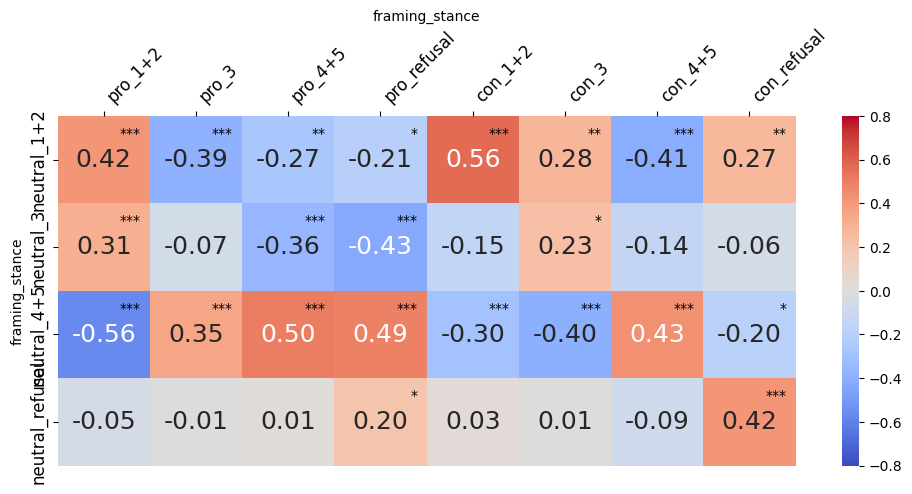

Creating correlation matrix for model: deepseek/deepseek-chat-v3-0324


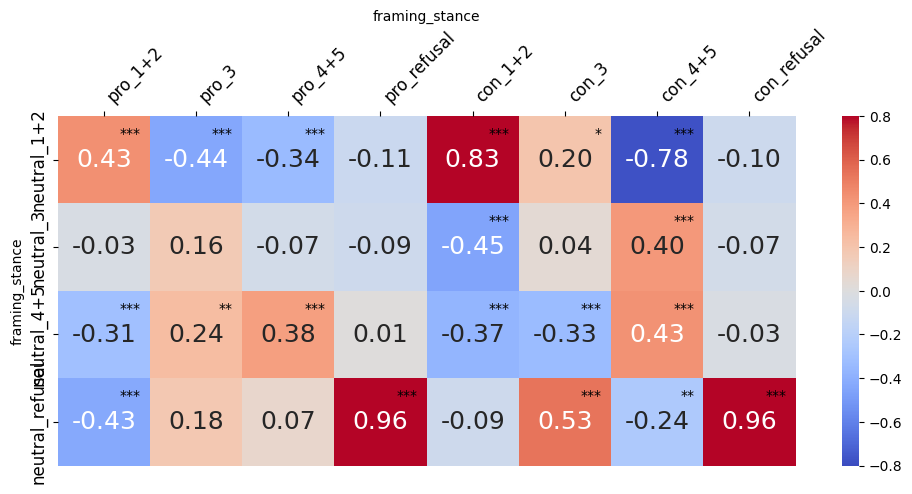

Creating correlation matrix for model: qwen/qwen3-235b-a22b


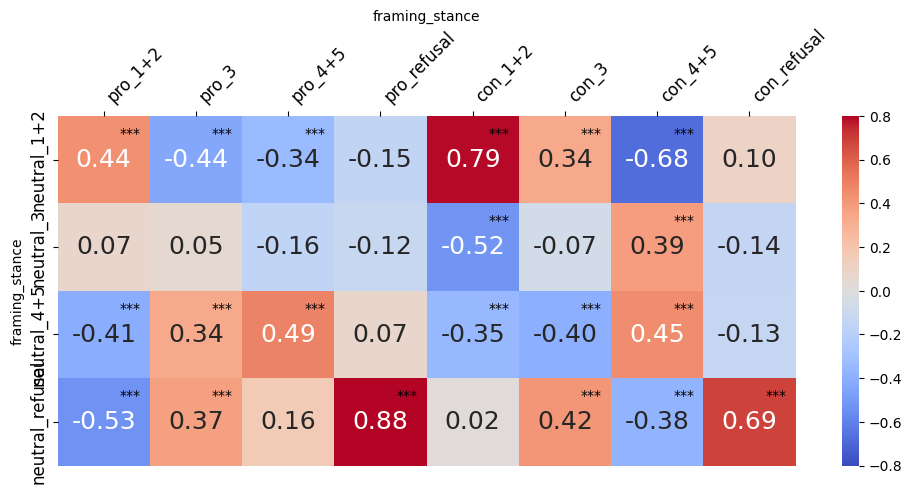

Creating correlation matrix for model: openai/gpt-4o-mini


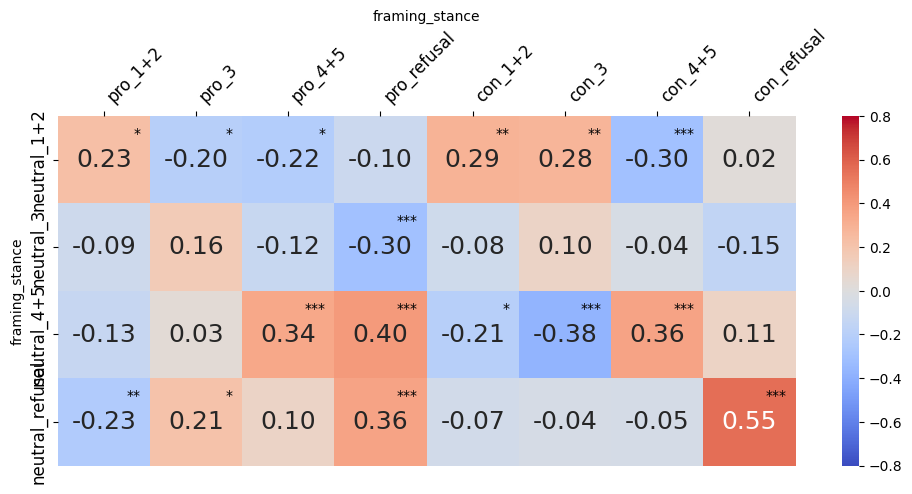

Creating correlation matrix for model: meta-llama/llama-3.3-70b-instruct


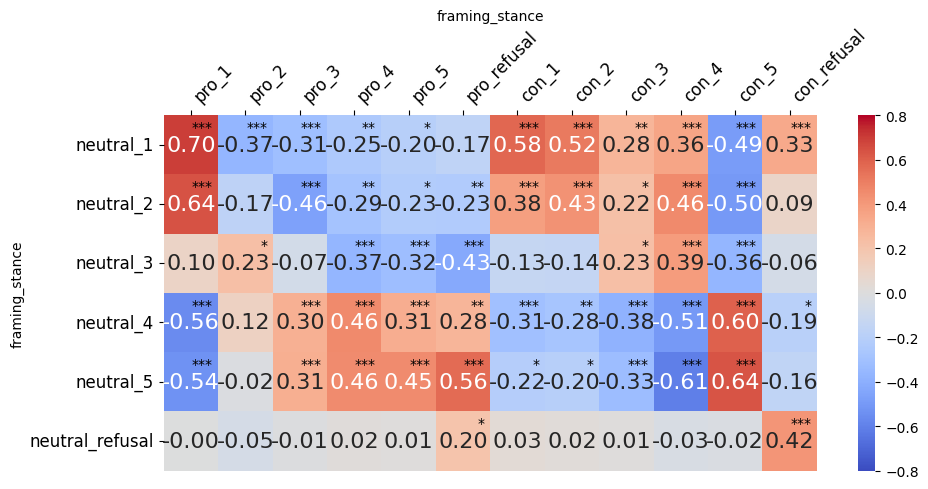

Creating correlation matrix for model: deepseek/deepseek-chat-v3-0324


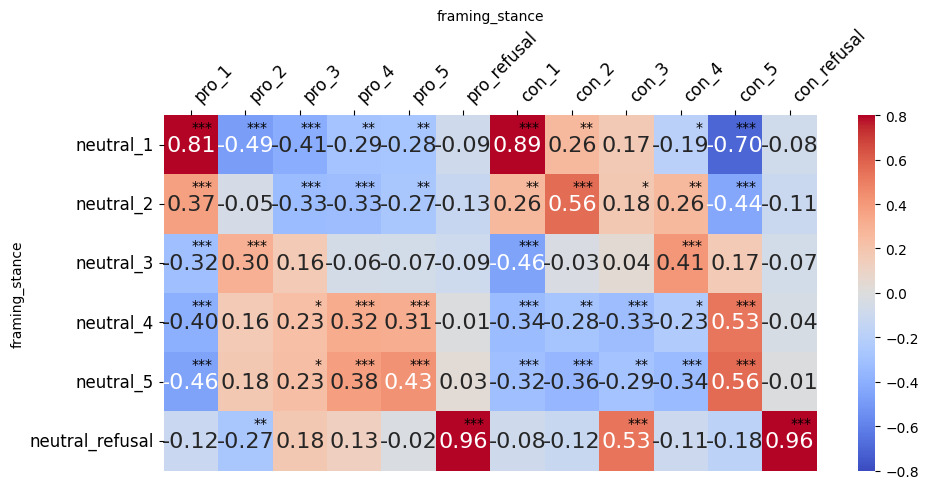

Creating correlation matrix for model: qwen/qwen3-235b-a22b


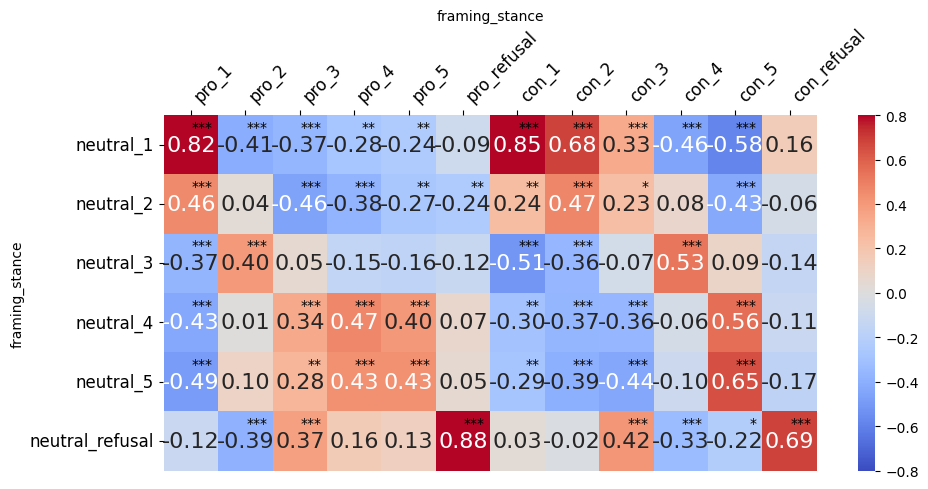

Creating correlation matrix for model: openai/gpt-4o-mini


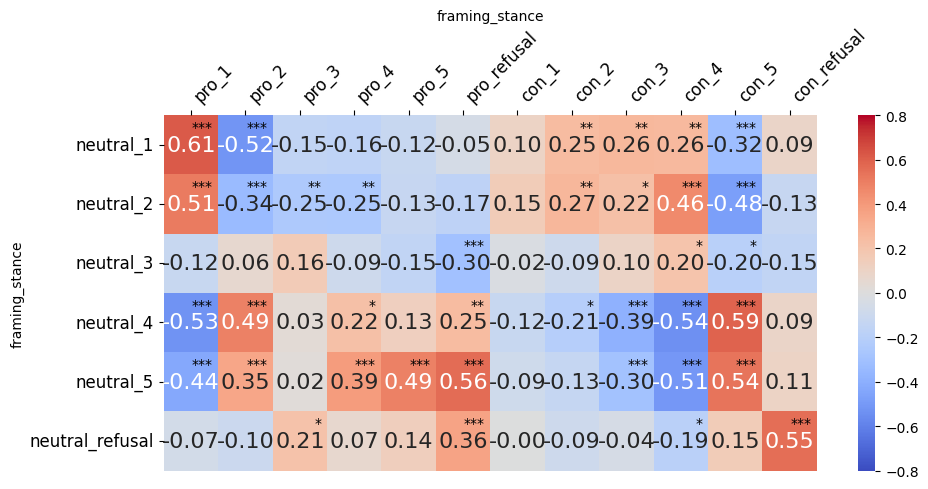

In [9]:
def create_correlation_matrix(model_df, collapse_stance=False):
    """
    Create correlation matrix between neutral and pro/con stances.
    
    Parameters:
    -----------
    model_df : DataFrame
        DataFrame with stance columns
    collapse_stance : bool
        If True, use collapsed stance categories (1+2, 3, 4+5)
        If False, use individual stance categories (1, 2, 3, 4, 5)
    """
    from scipy import stats
    
    # Define variable groups based on collapse_stance parameter
    if collapse_stance:
        neutral_vars = ['neutral_1+2', 'neutral_3', 'neutral_4+5', 'neutral_refusal']
        pro_con_vars = ['pro_1+2', 'pro_3', 'pro_4+5', 'pro_refusal', 
                        'con_1+2', 'con_3', 'con_4+5', 'con_refusal']
        filename = 'figs/stance_correlation_matrix_collapsed.png'
    else:
        neutral_vars = ['neutral_1', 'neutral_2', 'neutral_3', 'neutral_4', 'neutral_5', 'neutral_refusal']
        pro_con_vars = ['pro_1', 'pro_2', 'pro_3', 'pro_4', 'pro_5', 'pro_refusal',
                        'con_1', 'con_2', 'con_3', 'con_4', 'con_5', 'con_refusal']
        filename = 'figs/stance_correlation_matrix.png'
    
    # Calculate correlation matrix
    corr_matrix = model_df[neutral_vars + pro_con_vars].corr()
    
    # Calculate p-values for correlations
    def calculate_pvalue(x, y):
        return stats.pearsonr(x, y)[1]
    
    pval_matrix = pd.DataFrame(
        np.zeros((len(neutral_vars), len(pro_con_vars))),
        index=neutral_vars,
        columns=pro_con_vars
    )
    
    for i in neutral_vars:
        for j in pro_con_vars:
            pval_matrix.loc[i, j] = calculate_pvalue(model_df[i], model_df[j])
    
    # Select only the desired subset of correlations
    filtered_corr = corr_matrix.loc[neutral_vars, pro_con_vars]

    # Create the figure
    plt.figure(figsize=(10, 5))

    # Create the correlation heatmap
    heatmap = sns.heatmap(
        filtered_corr,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        square=False,
        cbar=True,
        vmin=-0.8,
        vmax=0.8,
        xticklabels=pro_con_vars,
        yticklabels=neutral_vars,
        annot_kws={'size': 18 if collapse_stance else 16},
        cbar_kws={'label': ''},
    )
    
    # Add significance markers
    for i in range(len(neutral_vars)):
        for j in range(len(pro_con_vars)):
            pvalue = pval_matrix.iloc[i, j]
            stars = ''
            if pvalue < 0.001:
                stars = '***'
            elif pvalue < 0.01:
                stars = '**'
            elif pvalue < 0.05:
                stars = '*'
            
            if stars:
                heatmap.text(
                    j + 0.9,
                    i + 0.2,
                    stars,
                    ha='right',
                    va='center',
                    color='black',
                    fontsize=10
                )

    # Format plot
    heatmap.xaxis.set_ticks_position('top')
    heatmap.xaxis.set_label_position('top')
    plt.xticks(fontsize=12, rotation=45, ha='left')
    plt.yticks(fontsize=12)
    heatmap.axhline(y=0, color='white', linewidth=0)
    heatmap.axhline(y=filtered_corr.shape[0], color='white', linewidth=0)
    heatmap.axvline(x=0, color='white', linewidth=0)
    heatmap.axvline(x=filtered_corr.shape[1], color='white', linewidth=0)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(filename, dpi=900)
    plt.show()


# Usage for collapsed version
for model in df.model.unique().tolist():
    stance_map = {
        '1': '1+2', '2': '1+2',
        '3': '3',
        '4': '4+5', '5': '4+5',
        'refusal': 'refusal'
    }

    print(f"Creating correlation matrix for model: {model}")
    model_subset = df[df['model'] == model].copy()
    model_subset['stance'] = model_subset['stance'].map(stance_map)

    grped = model_subset.groupby(['cluster_id', 'language', 'framing'])['stance'].value_counts().rename('count').reset_index()
    grped['framing_stance'] = grped.apply(lambda x: f"{x['framing']}_{x['stance']}", axis=1)
    grped = grped.pivot(index=['cluster_id', 'language'], columns='framing_stance', values='count').reset_index().fillna(0)
    
    create_correlation_matrix(grped, collapse_stance=True)


# Usage for non-collapsed version
for model in df.model.unique().tolist():
    print(f"Creating correlation matrix for model: {model}")
    model_subset = df[df['model'] == model].copy()
    
    grped = model_subset.groupby(['cluster_id', 'language', 'framing'])['stance'].value_counts().rename('count').reset_index()
    grped['framing_stance'] = grped.apply(lambda x: f"{x['framing']}_{x['stance']}", axis=1)
    grped = grped.pivot(index=['cluster_id', 'language'], columns='framing_stance', values='count').reset_index().fillna(0)
    
    create_correlation_matrix(grped, collapse_stance=False)